## Análisis de datos - Clase 6

### Taller práctico - análisis completo de un dataset

### Reducción de dimensionalidad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Importamos el dataset ya limpio y procesado anteriormente

In [2]:
import json

# Leer el JSON
with open("../datasets/carreras_24_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
carreras_24 = pd.read_csv("../datasets/carreras_24.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    carreras_24[col] = pd.to_timedelta(carreras_24[col])

# Restaurar categoricals
for col in categorical_cols:
    carreras_24[col] = carreras_24[col].astype("category")


carreras_24.head()

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,TrackTemp,Humidity,PitOutTime2,PitTime,PitTime_seconds,Pit,LapNumber_driver,DNF,Likely_DNF,Winner
0,ALB,23,101.190,1,1.0,NaT,NaT,17.981,40.443,35.860,...,32.1,49.0,NaT,NaT,0.0,0,57,True,False,NOR
1,ALB,23,120.191,2,1.0,NaT,NaT,18.394,56.603,45.194,...,32.2,49.0,NaT,NaT,0.0,0,57,True,False,NOR
2,ALB,23,95.776,3,1.0,NaT,NaT,19.929,42.240,33.607,...,31.8,49.0,NaT,NaT,0.0,0,57,True,False,NOR
3,ALB,23,90.060,4,1.0,NaT,NaT,18.099,37.915,34.046,...,31.8,49.0,NaT,NaT,0.0,0,57,True,False,NOR
4,ALB,23,90.369,5,1.0,NaT,NaT,18.232,37.968,34.169,...,31.7,50.0,NaT,NaT,0.0,0,57,True,False,NOR


In [3]:
carreras_24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26577 entries, 0 to 26576
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   Driver            26577 non-null  category       
 1   DriverNumber      26577 non-null  category       
 2   LapTime           26577 non-null  float64        
 3   LapNumber         26577 non-null  Int64          
 4   Stint             26577 non-null  category       
 5   PitOutTime        840 non-null    timedelta64[ns]
 6   PitInTime         849 non-null    timedelta64[ns]
 7   Sector1Time       26577 non-null  float64        
 8   Sector2Time       26577 non-null  float64        
 9   Sector3Time       26577 non-null  float64        
 10  SpeedI1           22460 non-null  float64        
 11  SpeedI2           26552 non-null  float64        
 12  SpeedFL           25728 non-null  float64        
 13  SpeedST           24422 non-null  float64        
 14  IsPers

### Preprocesamiento

#### Paso a paso para preparar carreras_24 para PCA

1. Elegir solo las columnas numéricas relevantes que tengan sentido para el análisis, por ejemplo tiempos, velocidades, temperaturas, etc.

2. PCA no admite NaN. Hacer el tratamiento correspondiente (borrar, imputar)

3. Escalar los datos. Sin escalar, los valores altos pueden dominar los resultados.

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Selección de columnas numéricas relevantes
cols_num = [
    'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
    'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'LapStartTime', 'Position', 'Time_weather',
    'AirTemp', 'TrackTemp', 'Humidity', 'PitTime_seconds', 'Pit'    
]

# 2. Filtrar las columnas y eliminar NaNs
df_pca = carreras_24[cols_num].dropna().copy()

# 3. Escalar los datos (media 0, desviación 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# 4. Aplicar PCA
pca = PCA(n_components=6)
components = pca.fit_transform(scaled_data)

# 5. Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# (Opcional) Información adicional: Driver, Team, etc.
df_components['Driver'] = carreras_24.loc[df_pca.index, 'Driver'].values
df_components['Team'] = carreras_24.loc[df_pca.index, 'Team'].values
df_components['EventName'] = carreras_24.loc[df_pca.index, 'EventName'].values
df_components['Winner'] = carreras_24.loc[df_pca.index, 'Winner'].values


In [5]:
df_components

,PC1,PC2,PC3,PC4,PC5,PC6,Driver,Team,EventName,Winner
0,0.735287,-0.923812,1.653759,-0.144453,-2.235377,0.244788,ALB,Williams,Abu Dhabi Grand Prix,NOR
1,3.023623,0.663158,1.959494,-0.276084,-2.693866,0.083777,ALB,Williams,Abu Dhabi Grand Prix,NOR
2,0.371210,-1.095169,1.506990,-0.134435,-1.799358,0.504017,ALB,Williams,Abu Dhabi Grand Prix,NOR
3,-0.488010,-1.463003,1.502240,-0.086621,-2.123038,0.724668,ALB,Williams,Abu Dhabi Grand Prix,NOR
4,-0.411544,-1.409549,1.419440,-0.063871,-2.190591,0.735574,ALB,Williams,Abu Dhabi Grand Prix,NOR
...,...,...,...,...,...,...,...,...,...,...
20102,0.480834,3.277095,1.176454,-0.314358,-0.009496,0.253660,ZHO,Kick Sauber,United States Grand Prix,NOR
20103,0.469263,3.311977,1.145188,-0.314231,0.062668,0.280527,ZHO,Kick Sauber,United States Grand Prix,NOR
20104,0.384379,3.328053,1.113055,-0.304824,0.042721,0.332172,ZHO,Kick Sauber,United States Grand Prix,NOR
20105,0.444398,3.367720,1.019771,-0.285343,0.028982,0.328449,ZHO,Kick Sauber,United States Grand Prix,NOR


### Graficamos dos componentes

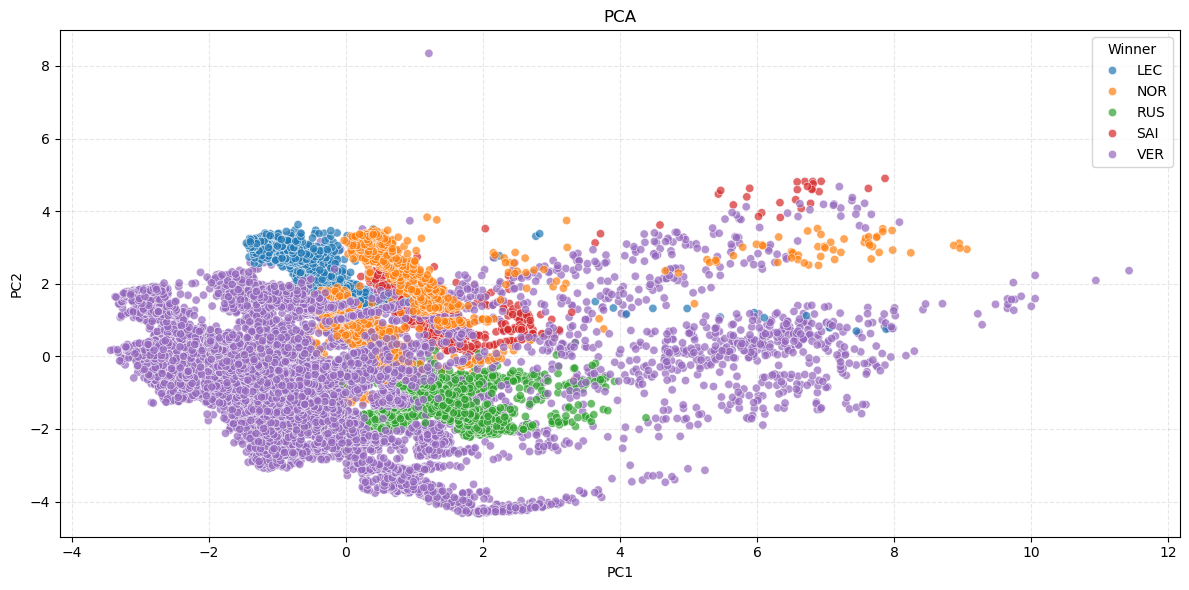

In [6]:

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Winner', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.19473789, 0.14890328, 0.13463513, 0.12490562, 0.07777257,
       0.07342201])

In [8]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.19473789, 0.34364117, 0.47827631, 0.60318193, 0.6809545 ,
       0.75437652])

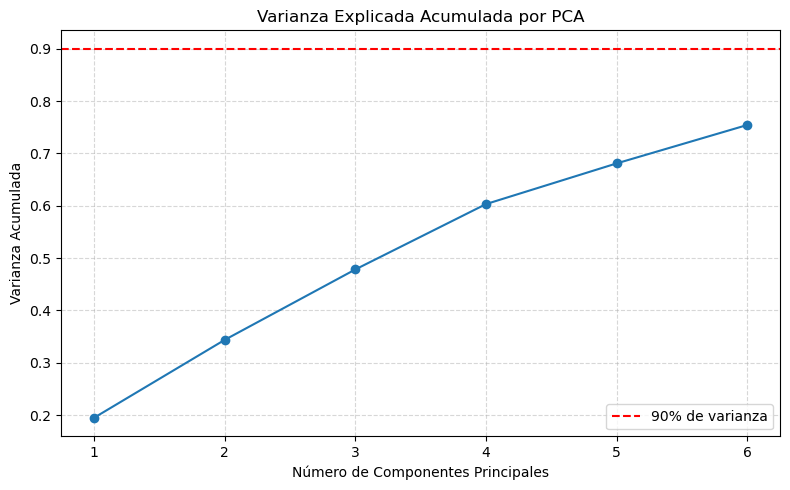

In [9]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
